# Библиотеки и данные

In [181]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
from scipy.special import softmax

In [182]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
trans = transforms.Compose((transforms.ToTensor()))

root_path = '/content/MNIST'

mnist_dataset_train = torchvision.datasets.MNIST(root_path, 
                                                 train=True,
                                                 transform=train_transform,
                                                 target_transform=None,
                                                 download=download)
mnist_dataset_test = torchvision.datasets.MNIST(root_path, 
                                                train=False, 
                                                transform=test_transform,
                                                target_transform=None,
                                                download=download)

num_calib = 1000
mnist_dataset_test, mnist_dataset_calib = torch.utils.data.random_split(mnist_dataset_test, [len(mnist_dataset_test)-num_calib, num_calib])

In [183]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(mnist_dataset_train, 
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_dataset_test,
                                          batch_size=batch_size,
                                          shuffle=False)

calib_loader = torch.utils.data.DataLoader(mnist_dataset_calib,
                                          batch_size=batch_size,
                                          shuffle=False)

# Сеть и цикл обучения

In [184]:
class simple_net(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape*input_channels, 512),
            nn.BatchNorm1d(512, eps = 1e-3, momentum = 0.1),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            # nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [185]:
# Experiments, training and validation loops
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    
    logsoft = nn.LogSoftmax(dim = 1)
    
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(n_epochs):

      epoch_train_loss = []
      epoch_val_loss = []
      epoch_train_accuracy = []
      epoch_val_accuracy = []

      model.train()
      for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = logsoft(model(x_batch))
        loss = criterion(output, y_batch) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())
        y_pred = output.max(dim = -1)[1]
        epoch_train_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred.cpu().numpy()))

      model.eval() 
      with torch.no_grad():
        for x_batch, y_batch in val_loader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)

          output = logsoft(model(x_batch))
          loss = criterion(output, y_batch) 

          epoch_val_loss.append(loss.item())
          y_pred = output.max(dim = -1)[1]
          epoch_val_accuracy.append(np.mean(y_batch.cpu().numpy() == y_pred.cpu().numpy()))

      train_loss.append(np.mean(epoch_train_loss))
      train_accuracy.append(np.mean(epoch_train_accuracy))

      val_loss.append(np.mean(epoch_val_loss))
      val_accuracy.append(np.mean(epoch_val_accuracy))

      print("Losses:")
      print(f"\t training loss: {train_loss[-1]:.5f}")
      print(f"\t validation(test) loss: {val_loss[-1]:.5f}")
      print("Accuaracies:")
      print(f"\t training accuracy: {train_accuracy[-1]:.5f}")
      print(f"\t validation(test) accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, train_accuracy, val_loss, val_accuracy

In [186]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = simple_net().to(device)
loss_func = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters(), lr = 1e-2, betas=(0.9, 0.95), eps=1e-6)

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

Losses:
	 training loss: 0.19600
	 validation(test) loss: 0.11030
Accuaracies:
	 training accuracy: 0.94070
	 validation(test) accuracy: 0.969


In [187]:
model_1 = model

# model_1 = simple_net().to(device)
# opt = torch.optim.Adam(model_1.parameters(), lr=1e-2, betas=(0.9, 0.95), eps=1e-6)
# tr_loss, tr_acc, val_loss, val_acc = train_model(model_1, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

model_2 = simple_net().to(device)
opt = torch.optim.Adam(model_2.parameters(), lr=1e-2, betas=(0.85, 0.9), eps=1e-6)
tr_loss, tr_acc, val_loss, val_acc = train_model(model_2, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

model_3 = simple_net().to(device)
opt = torch.optim.Adagrad(model_3.parameters(), lr=1e-2, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
tr_loss, tr_acc, val_loss, val_acc = train_model(model_3, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

model_4 = simple_net().to(device)
opt = torch.optim.SGD(model_4.parameters(), lr=1e-2, momentum=0.8)
tr_loss, tr_acc, val_loss, val_acc = train_model(model_4, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

model_5 = simple_net().to(device)
opt = torch.optim.SGD(model_5.parameters(), lr=1e-2, momentum=0.9)
tr_loss, tr_acc, val_loss, val_acc = train_model(model_5, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

Losses:
	 training loss: 0.19404
	 validation(test) loss: 0.09990
Accuaracies:
	 training accuracy: 0.94146
	 validation(test) accuracy: 0.970
Losses:
	 training loss: 0.18552
	 validation(test) loss: 0.11088
Accuaracies:
	 training accuracy: 0.94556
	 validation(test) accuracy: 0.969
Losses:
	 training loss: 0.31962
	 validation(test) loss: 0.17236
Accuaracies:
	 training accuracy: 0.91196
	 validation(test) accuracy: 0.952
Losses:
	 training loss: 0.26798
	 validation(test) loss: 0.14018
Accuaracies:
	 training accuracy: 0.92353
	 validation(test) accuracy: 0.961


In [188]:
models = [model_1, model_2, model_3, model_4, model_5]

# Функции неопределенности

A1 и A2 заданы функциями s1 и s2 \\
A3 и А4 задаются классами NoizeScores и EnsambleScores

In [189]:
def s1(score):
  return 1 - score

def s2(score):
  score = torch.tensor(score)
  score, ind = torch.sort(score, dim=1, descending=True)
  score = torch.cumsum(score, dim=1) - score
  out = score.gather(1, ind.argsort(1))
  out = np.array(out)
  return out 

# def s3(scores):
#   scores = np.array(scores)
#   for i in range(scores.shape[0]):
#       s = scores[i]
#       i_max1 = np.argmax(s)
#       max1 = s[i_max1]
#       s[i_max1] = 0
#       i_max2 = np.argmax(s)
#       max2 = s[i_max2]
#       scores[i].fill(max1)
#       scores[i, i_max1] = max2
      
#   return torch.tensor(scores)

# def s4(scores):
#   scores = np.array(scores)
#   return np.expand_dims(np.sum(np.sqrt(scores), axis=1), axis=1) - np.sqrt(scores)

In [190]:
class NoizeScores:
    def __init__(self, model, sigma, n):
        self.model = model
        self.sigma = sigma
        self.n = n
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' # model.device
    
    def __call__(self, x):
        logsoft = nn.LogSoftmax(dim = 1)
        with torch.no_grad():
            # logits = self.model(x).detach().cpu().numpy()
            logits = self.model(x)
            logits = logsoft(logits).detach().cpu().numpy()
            S = 0
            x = x.detach().cpu().numpy()
            for i in range(self.n):
                gauss = np.random.normal(0.0, self.sigma, x.shape)
                new_x = x + gauss
                new_x = torch.tensor(new_x).to(self.device)
                new_x = new_x.to(torch.float32)

                # new_logits = self.model(new_x).detach().cpu().numpy()
                new_logits = self.model(new_x)
                new_logits = logsoft(new_logits).detach().cpu().numpy()

                # S += normalize((new_logits - logits)**2)
                S += (new_logits - logits)**2
        S = S/self.n
        return np.array(S)

def normalize(A):
    A = A.T
    mins = np.min(A, axis=0)
    maxs = np.max(A, axis=0)
    rng = maxs - mins
    return (((maxs - A)) / rng).T

In [191]:
class EnsambleScores:
    def __init__(self, models):
        self.models = models
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' # model.device
    
    def __call__(self, *args, **kwargs):
        with torch.no_grad():
            # all_logits = np.array([model(*args, **kwargs).detach().cpu().numpy() for model in self.models])
            # logits = np.mean(softmax(all_logits, axis=1), axis=0)

            # scores = np.std(all_logits, axis=0)
            # scores = np.std(softmax(all_logits, axis=1), axis=0)

            logsoft = nn.LogSoftmax(dim = 1)
            all_logits = np.array([logsoft(model(*args, **kwargs)).detach().cpu().numpy() for model in self.models])
            scores = np.std(all_logits, axis=0)
        return scores

# Oбъединение мер

Для объединения мер посчитаем значения мер A1, A2, A3 и А4 на калибровочном множестве. 

S_i - значения на истинном классе, res_i - на ложном.



In [192]:
# Считает n значений для всех мер на точках из loader.

def points(model, models, loader, device, n=-1):
    flag = 0

    S1 = []
    S2 = []
    S3 = []
    S4 = []

    res1 = np.array([])
    res2 = np.array([])
    res3 = np.array([])
    res4 = np.array([])

    f_s1 = s1
    f_s2 = s2
    f_s3 = NoizeScores(model, 0.05, 10)
    f_s4 = EnsambleScores(models)

    for x_batch, y_batch in loader:
      logits = model(x_batch.to(device))
            
      with torch.no_grad():
        logits = logits.detach().cpu()
        # scores = torch.exp(logits)
        scores = torch.softmax(logits, dim=1)

        scores1 = np.array(f_s1(scores))
        scores2 = np.array(f_s2(scores))
        scores3 = np.array(f_s3(x_batch.to(device)))
        scores4 = np.array(f_s4(x_batch.to(device)))

        for i, label in enumerate(y_batch):
          S1.append(scores1[i, label])
          S2.append(scores2[i, label])
          S3.append(scores3[i, label])
          S4.append(scores4[i, label])

          res1 = np.concatenate((res1, scores1[i, :label], scores1[i, (label+1):]))
          res2 = np.concatenate((res2, scores2[i, :label], scores2[i, (label+1):]))
          res3 = np.concatenate((res3, scores3[i, :label], scores3[i, (label+1):]))
          res4 = np.concatenate((res4, scores4[i, :label], scores4[i, (label+1):]))
        
        flag += 1
        if flag == n:
          break

    S1 = np.array(S1)
    S2 = np.array(S2)
    S3 = np.array(S3)
    S4 = np.array(S4)

    return S1, S2, S3, S4, res1, res2, res3, res4

In [193]:
SIZES_calib = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

In [194]:
# Для двух мер вычисляет порог qhat и средний размер множеств на калибровочном множестве.

def find_theta(S1, S2, res1, res2, alpha, a=0.0, b=1.0, n=21):
    thetas = np.expand_dims(np.linspace(a, b, n), axis=0)
    S1 = np.expand_dims(S1, axis=0)
    S2 = np.expand_dims(S2, axis=0)
    res1 = np.expand_dims(res1, axis=0)
    res2 = np.expand_dims(res2, axis=0)

    S = np.dot(thetas.T, S2) + np.dot((1-thetas).T, S1)
    res = np.dot(thetas.T, res2) + np.dot((1-thetas).T, res1)

    qhat = np.quantile(S, 1-alpha, axis=1, interpolation='higher')
    
    gammas = (np.sum([S[i] <= qhat[i] for i in range(n)], axis=1) + np.sum([res[i] <= qhat[i] for i in range(n)], axis=1))/S.shape[1]

    return gammas, qhat

In [195]:
num_test = 9000
num_calib = 1000

mnist_dataset_test = torchvision.datasets.MNIST(root_path, 
                                                train=False, 
                                                transform=test_transform,
                                                target_transform=None,
                                                download=download)

mnist_dataset_test, mnist_dataset_calib = torch.utils.data.random_split(mnist_dataset_test, [num_test, num_calib])

test_loader = DataLoader(mnist_dataset_test,
                    batch_size=batch_size,
                    shuffle=False)

calib_loader = DataLoader(mnist_dataset_calib,
                              batch_size=batch_size,
                              shuffle=False)

## Графики на калибровочном множестве

In [196]:
S1, S2, S3, S4, res1, res2, res3, res4 = points(model, models, calib_loader, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [197]:
n = 201
alpha = 0.01
thetas = np.linspace(0, 1, n)

SIZES_calib['$A_{12}$'], qhat12 = find_theta(S1, S2, res1, res2, alpha, n=n)
SIZES_calib['$A_{13}$'], qhat13 = find_theta(S1, S3, res1, res3, alpha, n=n)
SIZES_calib['$A_{14}$'], qhat14 = find_theta(S1, S4, res1, res4, alpha, n=n)
SIZES_calib['$A_{23}$'], qhat23 = find_theta(S2, S3, res2, res3, alpha, n=n)
SIZES_calib['$A_{24}$'], qhat24 = find_theta(S2, S4, res2, res4, alpha, n=n)
SIZES_calib['$A_{34}$'], qhat34 = find_theta(S3, S4, res3, res4, alpha, n=n)

## Графики на тесте

In [198]:
S1_test, S2_test, S3_test, S4_test, res1_test, res2_test, res3_test, res4_test = points(model, models, test_loader, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [199]:
# В отличии от find_theta принимает раннее посчитанные qhat 
# и возвращает среднее размер множества и вероятность покрытия. 

def find_theta_test(S1, S2, res1, res2, alpha, qhat, a=0.0, b=1.0, n=21):
    thetas = np.expand_dims(np.linspace(a, b, n), axis=0)
    S1 = np.expand_dims(S1, axis=0)
    S2 = np.expand_dims(S2, axis=0)
    res1 = np.expand_dims(res1, axis=0)
    res2 = np.expand_dims(res2, axis=0)
    
    S = np.dot(thetas.T, S2) + np.dot((1-thetas).T, S1)
    res = np.dot(thetas.T, res2) + np.dot((1-thetas).T, res1)
    
    gammas = (np.sum([S[i] <= qhat[i] for i in range(n)], axis=1) + np.sum([res[i] <= qhat[i] for i in range(n)], axis=1))/S.shape[1]
    cover = np.sum([S[i] <= qhat[i] for i in range(n)], axis=1)/S.shape[1]

    return gammas, cover

In [200]:
SIZES_test = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

COVER = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

In [201]:
SIZES_test['$A_{12}$'], COVER['$A_{12}$'] = find_theta_test(S1_test, S2_test, res1_test, res2_test, alpha, qhat12, n=n)
SIZES_test['$A_{13}$'], COVER['$A_{13}$'] = find_theta_test(S1_test, S3_test, res1_test, res3_test, alpha, qhat13, n=n)
SIZES_test['$A_{14}$'], COVER['$A_{14}$'] = find_theta_test(S1_test, S4_test, res1_test, res4_test, alpha, qhat14, n=n)
SIZES_test['$A_{23}$'], COVER['$A_{23}$'] = find_theta_test(S2_test, S3_test, res2_test, res3_test, alpha, qhat23, n=n)
SIZES_test['$A_{24}$'], COVER['$A_{24}$'] = find_theta_test(S2_test, S4_test, res2_test, res4_test, alpha, qhat24, n=n)
SIZES_test['$A_{34}$'], COVER['$A_{34}$'] = find_theta_test(S3_test, S4_test, res3_test, res4_test, alpha, qhat34, n=n)

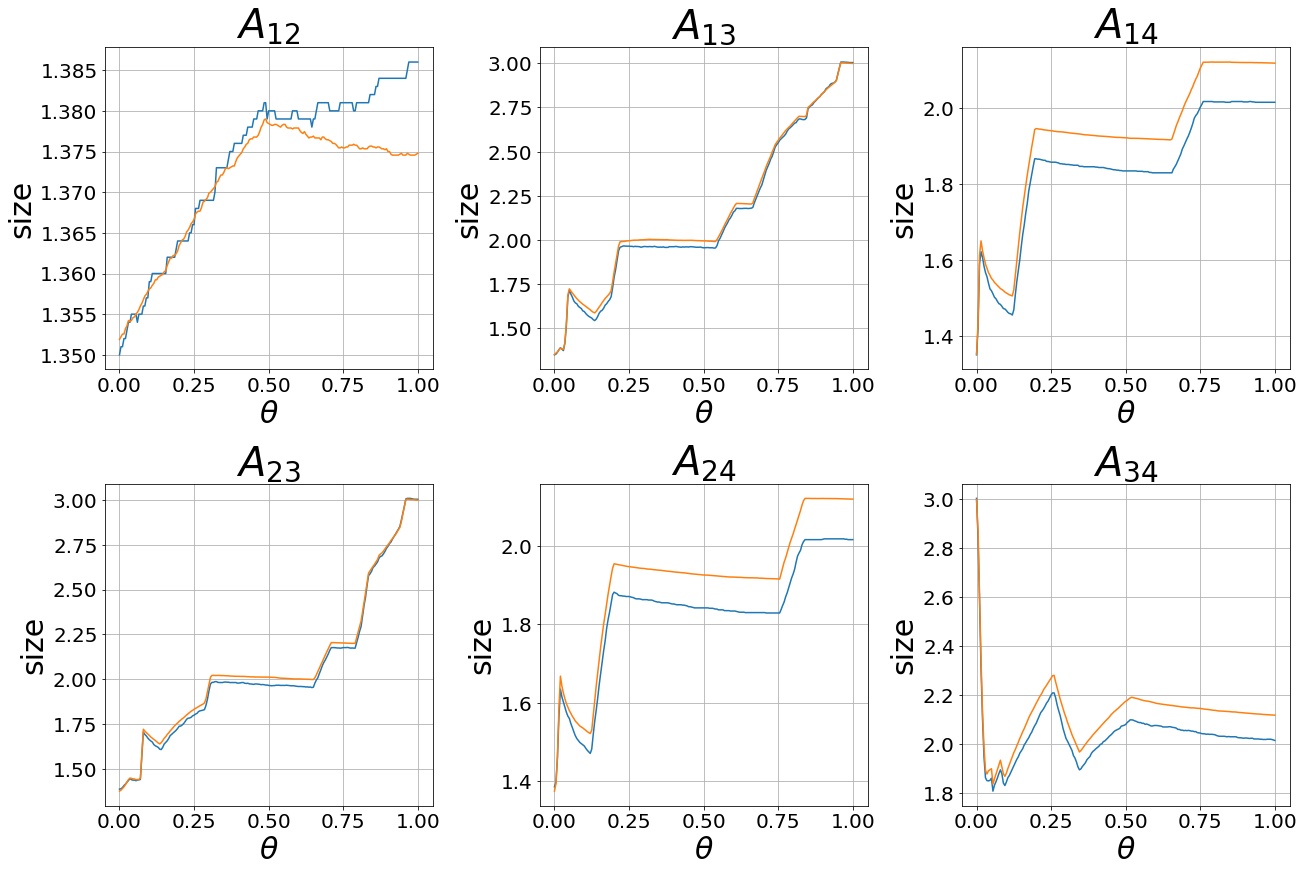

In [202]:
# Синяя линия - размер множеств на калибровке, 
# оранжевая - на тесте

fig, ax = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
# plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=40) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend


names = ['$A_{12}$', '$A_{13}$', '$A_{14}$', '$A_{23}$', '$A_{24}$', '$A_{34}$']
for i, name in enumerate(names):
  k = i // 3
  j = i % 3
  ax[k][j].set_title(name)
  ax[k][j].set_xlabel(r'$\theta$')
  ax[k][j].set_ylabel('size')
  ax[k][j].plot(thetas, SIZES_calib[name])
  ax[k][j].plot(thetas, SIZES_test[name])
  ax[k][j].grid()

plt.savefig("/content/fig1.pdf")
plt.show()

Вероятности покрытия на тесте. При $\alpha = 0.01$ значения вероятности покрытия должны лежать выше $0.99$.

По-хорошему это должно илюстрировать корректность метода, но наблюдается зависимость от разбиения данных на калибровку и тест.

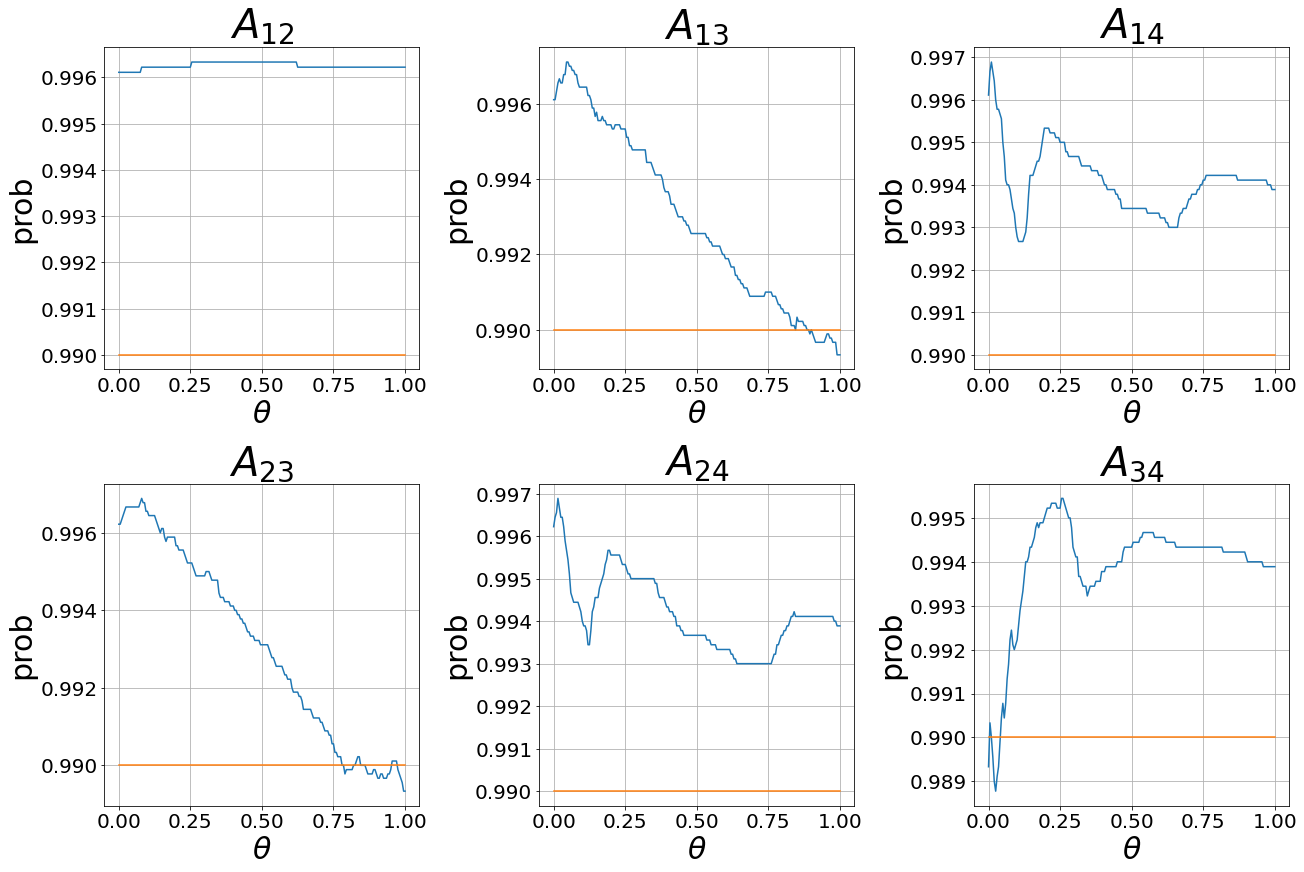

In [203]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
# plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=40) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend


names = ['$A_{12}$', '$A_{13}$', '$A_{14}$', '$A_{23}$', '$A_{24}$', '$A_{34}$']
for i, name in enumerate(names):
  k = i // 3
  j = i % 3
  ax[k][j].set_title(name)
  ax[k][j].set_xlabel(r'$\theta$')
  ax[k][j].set_ylabel('prob')
  # ax[k][j].plot(thetas, SIZES_calib[name])
  # ax[k][j].plot(thetas, SIZES_test[name])
  ax[k][j].plot(thetas, COVER[name])
  ax[k][j].plot([0.0, 1.0], [0.99, 0.99])
  ax[k][j].grid()

plt.savefig("/content/fig2.pdf")
plt.show()

# Изменение размера обучающей выборки

In [ ]:
# num_calib = 1000
# num_test = 9000
# num_train = 60000

batch_size = 128
all_dataset = ConcatDataset([mnist_dataset_test, mnist_dataset_calib, mnist_dataset_train])

k = 5
l = 60000//k

n = 201
alpha = 0.01
thetas = np.linspace(0, 1, n)

names = ['$A_{12}$', '$A_{13}$', '$A_{14}$', '$A_{23}$', '$A_{24}$', '$A_{34}$']

SIZES_calib = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

SIZES_test = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

COVER = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

THETAS = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}
          
THETAS_STD = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}

for i in range(1, k+1):
    num_train = l*i
    num_test = 9000
    num_calib = 1000
    num = num_train + num_test + num_calib
    for j in range(5):
        BEST_THETA = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}
        print(i, j)
        mnist_dataset_train, mnist_dataset_test, mnist_dataset_calib, _ = torch.utils.data.random_split(all_dataset, 
                                                                                                        [num_train, num_test, num_calib, len(all_dataset)-num])

        train_loader = DataLoader(mnist_dataset_train, 
                                  batch_size=batch_size,
                                  shuffle=True)

        test_loader = DataLoader(mnist_dataset_test,
                                batch_size=batch_size,
                                shuffle=False)

        calib_loader = DataLoader(mnist_dataset_calib,
                                  batch_size=batch_size,
                                  shuffle=False)
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        loss_func = nn.NLLLoss()
        
        model_1 = simple_net().to(device)
        opt = torch.optim.Adam(model_1.parameters(), lr = 1e-2, betas=(0.9, 0.95), eps=1e-6)
        tr_loss, tr_acc, val_loss, val_acc = train_model(model_1, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

        model_2 = simple_net().to(device)
        opt = torch.optim.Adam(model_2.parameters(), lr=1e-2, betas=(0.85, 0.9), eps=1e-6)
        tr_loss, tr_acc, val_loss, val_acc = train_model(model_2, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

        model_3 = simple_net().to(device)
        opt = torch.optim.Adagrad(model_3.parameters(), lr=1e-2, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
        tr_loss, tr_acc, val_loss, val_acc = train_model(model_3, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

        model_4 = simple_net().to(device)
        opt = torch.optim.SGD(model_4.parameters(), lr=1e-2, momentum=0.8)
        tr_loss, tr_acc, val_loss, val_acc = train_model(model_4, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

        model_5 = simple_net().to(device)
        opt = torch.optim.SGD(model_5.parameters(), lr=1e-2, momentum=0.9)
        tr_loss, tr_acc, val_loss, val_acc = train_model(model_5, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

        models = [model_1, model_2, model_3, model_4, model_5]

        S1, S2, S3, S4, res1, res2, res3, res4 = points(model, models, calib_loader, device)
        S1_test, S2_test, S3_test, S4_test, res1_test, res2_test, res3_test, res4_test = points(model, models, test_loader, device)

        SIZES_calib['$A_{12}$'], qhat12 = find_theta(S1, S2, res1, res2, alpha, n=n)
        SIZES_calib['$A_{13}$'], qhat13 = find_theta(S1, S3, res1, res3, alpha, n=n)
        SIZES_calib['$A_{14}$'], qhat14 = find_theta(S1, S4, res1, res4, alpha, n=n)
        SIZES_calib['$A_{23}$'], qhat23 = find_theta(S2, S3, res2, res3, alpha, n=n)
        SIZES_calib['$A_{24}$'], qhat24 = find_theta(S2, S4, res2, res4, alpha, n=n)
        SIZES_calib['$A_{34}$'], qhat34 = find_theta(S3, S4, res3, res4, alpha, n=n)

        SIZES_test['$A_{12}$'], COVER['$A_{12}$'] = find_theta_test(S1_test, S2_test, res1_test, res2_test, alpha, qhat12, n=n)
        SIZES_test['$A_{13}$'], COVER['$A_{13}$'] = find_theta_test(S1_test, S3_test, res1_test, res3_test, alpha, qhat13, n=n)
        SIZES_test['$A_{14}$'], COVER['$A_{14}$'] = find_theta_test(S1_test, S4_test, res1_test, res4_test, alpha, qhat14, n=n)
        SIZES_test['$A_{23}$'], COVER['$A_{23}$'] = find_theta_test(S2_test, S3_test, res2_test, res3_test, alpha, qhat23, n=n)
        SIZES_test['$A_{24}$'], COVER['$A_{24}$'] = find_theta_test(S2_test, S4_test, res2_test, res4_test, alpha, qhat24, n=n)
        SIZES_test['$A_{34}$'], COVER['$A_{34}$'] = find_theta_test(S3_test, S4_test, res3_test, res4_test, alpha, qhat34, n=n)

        for name in names:
            BEST_THETA[name].append(np.min(SIZES_test[name])) 

    for name in names:
        THETAS[name].append(np.mean(SIZES_test[name])) 
        THETAS_STD[name].append(np.std(SIZES_test[name]))

1 0
Losses:
	 training loss: 0.33007
	 validation(test) loss: 0.24766
Accuaracies:
	 training accuracy: 0.89583
	 validation(test) accuracy: 0.928
Losses:
	 training loss: 0.34820
	 validation(test) loss: 0.24603
Accuaracies:
	 training accuracy: 0.88985
	 validation(test) accuracy: 0.927
Losses:
	 training loss: 0.31480
	 validation(test) loss: 0.21326
Accuaracies:
	 training accuracy: 0.90528
	 validation(test) accuracy: 0.936
Losses:
	 training loss: 0.62006
	 validation(test) loss: 0.34741
Accuaracies:
	 training accuracy: 0.83644
	 validation(test) accuracy: 0.905
Losses:
	 training loss: 0.53419
	 validation(test) loss: 0.28444
Accuaracies:
	 training accuracy: 0.84425
	 validation(test) accuracy: 0.916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


1 1
Losses:
	 training loss: 0.33936
	 validation(test) loss: 0.20163
Accuaracies:
	 training accuracy: 0.89714
	 validation(test) accuracy: 0.933
Losses:
	 training loss: 0.34226
	 validation(test) loss: 0.20443
Accuaracies:
	 training accuracy: 0.89248
	 validation(test) accuracy: 0.940
Losses:
	 training loss: 0.31848
	 validation(test) loss: 0.20295
Accuaracies:
	 training accuracy: 0.90586
	 validation(test) accuracy: 0.939
Losses:
	 training loss: 0.62660
	 validation(test) loss: 0.33004
Accuaracies:
	 training accuracy: 0.83500
	 validation(test) accuracy: 0.909
Losses:
	 training loss: 0.54034
	 validation(test) loss: 0.27498
Accuaracies:
	 training accuracy: 0.84314
	 validation(test) accuracy: 0.918
1 2
Losses:
	 training loss: 0.35148
	 validation(test) loss: 0.21320
Accuaracies:
	 training accuracy: 0.88846
	 validation(test) accuracy: 0.935
Losses:
	 training loss: 0.33195
	 validation(test) loss: 0.20016
Accuaracies:
	 training accuracy: 0.89824
	 validation(test) accurac

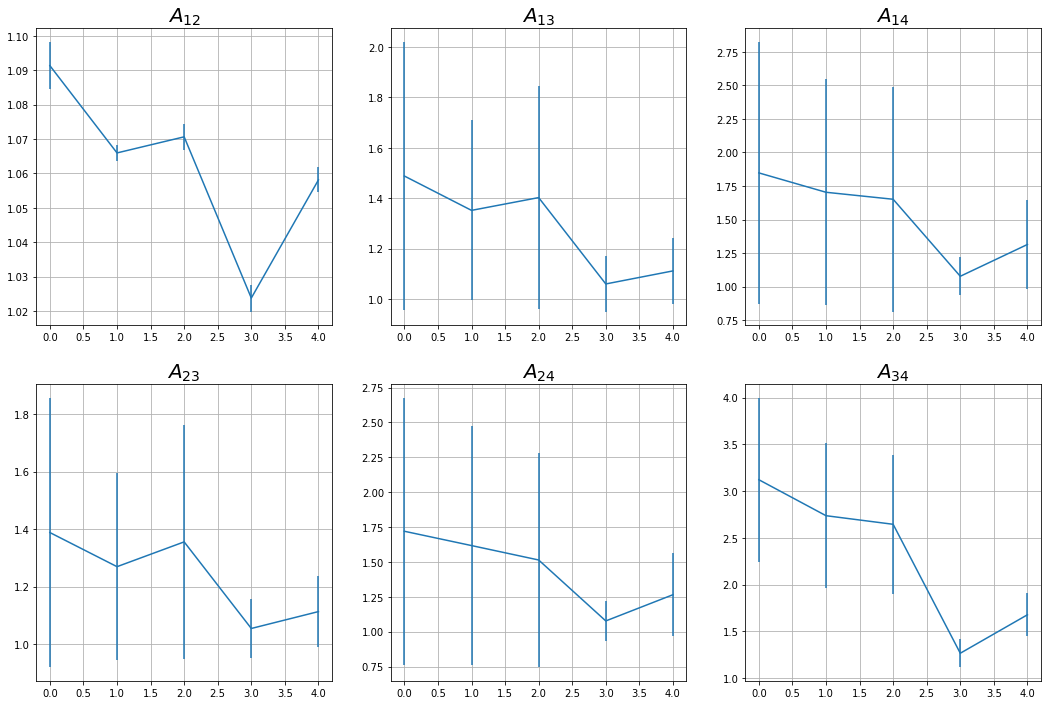

In [ ]:
# Синяя линия - размер множеств на калибровке, 
# оранжевая - на тесте

fig, ax = plt.subplots(2, 3, figsize=(18, 12))

names = ['$A_{12}$', '$A_{13}$', '$A_{14}$', '$A_{23}$', '$A_{24}$', '$A_{34}$']
for i, name in enumerate(names):
  k = i // 3
  j = i % 3
  ax[k][j].set_title(name, fontsize=20)
  # ax[k][j].set_xlabel(r'$\theta$', fontsize=16)
  # ax[k][j].set_ylabel('size', fontsize=16)
  # ax[k][j].plot(THETAS[name]) #np.linspace(30000, 60000, k+1)
  ax[k][j].errorbar(range(5), THETAS[name], yerr=THETAS_STD[name])
  ax[k][j].grid()

plt.savefig("/content/fig1.pdf")
plt.show()

In [ ]:
THETAS['$A_{12}$']

[1.0558933112216693,
 1.0383969043670536,
 1.040191818684356,
 1.0710016583747928,
 1.0449369817578773,
 1.0270961857379768]

# Усреднение результата

In [ ]:
# num_calib = 1000
# num_test = 9000
# num_train = 60000

batch_size = 128
all_dataset = ConcatDataset([mnist_dataset_test, mnist_dataset_calib, mnist_dataset_train])

n = 201
alpha = 0.01
thetas = np.linspace(0, 1, n)

names = ['$A_{12}$', '$A_{13}$', '$A_{14}$', '$A_{23}$', '$A_{24}$', '$A_{34}$']

SIZES_calib = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

SIZES_test = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

COVER = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

BEST_THETA = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}

THETAS = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}
          
THETAS_STD = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}

OLD = {'$A_{12}$': [],
        '$A_{13}$': [],
        '$A_{14}$': [],
        '$A_{23}$': [],
        '$A_{24}$': [],
        '$A_{34}$': []}

OLD_MEAN = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

OLD_STD = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

NEW = {'$A_{12}$': [],
        '$A_{13}$': [],
        '$A_{14}$': [],
        '$A_{23}$': [],
        '$A_{24}$': [],
        '$A_{34}$': []}

NEW_MEAN = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

NEW_STD = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

DELTA = {'$A_{12}$': [],
        '$A_{13}$': [],
        '$A_{14}$': [],
        '$A_{23}$': [],
        '$A_{24}$': [],
        '$A_{34}$': []}

DELTA_MEAN = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

DELTA_STD = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

num_train = 60000
num_test = 9000
num_calib = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_func = nn.NLLLoss()

for i in range(5):
    mnist_dataset_train, mnist_dataset_test_calib = torch.utils.data.random_split(all_dataset, 
                                                                                  [num_train, num_test + num_calib])

    train_loader = DataLoader(mnist_dataset_train, 
                              batch_size=batch_size,
                              shuffle=True)
    
    model_1 = simple_net().to(device)
    opt = torch.optim.Adam(model_1.parameters(), lr = 1e-2, betas=(0.9, 0.95), eps=1e-6)
    tr_loss, tr_acc, val_loss, val_acc = train_model(model_1, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

    model_2 = simple_net().to(device)
    opt = torch.optim.Adam(model_2.parameters(), lr=1e-2, betas=(0.85, 0.9), eps=1e-6)
    tr_loss, tr_acc, val_loss, val_acc = train_model(model_2, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

    model_3 = simple_net().to(device)
    opt = torch.optim.Adagrad(model_3.parameters(), lr=1e-2, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    tr_loss, tr_acc, val_loss, val_acc = train_model(model_3, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

    model_4 = simple_net().to(device)
    opt = torch.optim.SGD(model_4.parameters(), lr=1e-2, momentum=0.8)
    tr_loss, tr_acc, val_loss, val_acc = train_model(model_4, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

    model_5 = simple_net().to(device)
    opt = torch.optim.SGD(model_5.parameters(), lr=1e-2, momentum=0.9)
    tr_loss, tr_acc, val_loss, val_acc = train_model(model_5, train_loader, test_loader, criterion=loss_func, optimizer=opt, n_epochs=1, device=device)

    models = [model_1, model_2, model_3, model_4, model_5]

    for j in range(3):
        print(i, j)
        mnist_dataset_test, mnist_dataset_calib = torch.utils.data.random_split(mnist_dataset_test_calib, 
                                                                                  [num_test, num_calib])
        test_loader = DataLoader(mnist_dataset_test,
                            batch_size=batch_size,
                            shuffle=False)

        calib_loader = DataLoader(mnist_dataset_calib,
                              batch_size=batch_size,
                              shuffle=False)

        S1, S2, S3, S4, res1, res2, res3, res4 = points(model, models, calib_loader, device)
        S1_test, S2_test, S3_test, S4_test, res1_test, res2_test, res3_test, res4_test = points(model, models, test_loader, device)

        SIZES_calib['$A_{12}$'], qhat12 = find_theta(S1, S2, res1, res2, alpha, n=n)
        SIZES_calib['$A_{13}$'], qhat13 = find_theta(S1, S3, res1, res3, alpha, n=n)
        SIZES_calib['$A_{14}$'], qhat14 = find_theta(S1, S4, res1, res4, alpha, n=n)
        SIZES_calib['$A_{23}$'], qhat23 = find_theta(S2, S3, res2, res3, alpha, n=n)
        SIZES_calib['$A_{24}$'], qhat24 = find_theta(S2, S4, res2, res4, alpha, n=n)
        SIZES_calib['$A_{34}$'], qhat34 = find_theta(S3, S4, res3, res4, alpha, n=n)

        SIZES_test['$A_{12}$'], COVER['$A_{12}$'] = find_theta_test(S1_test, S2_test, res1_test, res2_test, alpha, qhat12, n=n)
        SIZES_test['$A_{13}$'], COVER['$A_{13}$'] = find_theta_test(S1_test, S3_test, res1_test, res3_test, alpha, qhat13, n=n)
        SIZES_test['$A_{14}$'], COVER['$A_{14}$'] = find_theta_test(S1_test, S4_test, res1_test, res4_test, alpha, qhat14, n=n)
        SIZES_test['$A_{23}$'], COVER['$A_{23}$'] = find_theta_test(S2_test, S3_test, res2_test, res3_test, alpha, qhat23, n=n)
        SIZES_test['$A_{24}$'], COVER['$A_{24}$'] = find_theta_test(S2_test, S4_test, res2_test, res4_test, alpha, qhat24, n=n)
        SIZES_test['$A_{34}$'], COVER['$A_{34}$'] = find_theta_test(S3_test, S4_test, res3_test, res4_test, alpha, qhat34, n=n)

        for name in names:
            NEW[name].append(np.min(SIZES_test[name][1:-1]))
            OLD[name].append(min(SIZES_test[name][0], SIZES_test[name][-1]))
            BEST_THETA[name].append(thetas[np.argmin(SIZES_test[name][1:-1])])
            DELTA[name].append((OLD[name][-1] - NEW[name][-1])/OLD[name][-1])

for name in names:
    THETAS[name].append(np.mean(BEST_THETA[name]))
    THETAS_STD[name].append(np.std(BEST_THETA[name]))
    OLD_MEAN[name].append(np.mean(OLD[name]))
    OLD_STD[name].append(np.std(OLD[name]))
    NEW_MEAN[name].append(np.mean(NEW[name]))
    NEW_STD[name].append(np.std(NEW[name]))
    DELTA_MEAN[name].append(np.mean(DELTA[name]))
    DELTA_STD[name].append(np.std(DELTA[name]))

In [ ]:
for name in names:
  print(name)
  print(f'{round(NEW_MEAN[name][0], 3)} \pm {round(NEW_STD[name][0], 3)}')
  print(f'{round(OLD_MEAN[name][0], 3)} \pm {round(OLD_STD[name][0], 3)}')
  print(f'{round(DELTA_MEAN[name][0], 3)} \pm {round(DELTA_STD[name][0], 3)}')
  # print('old', name, OLD_MEAN[name][0],'\pm', OLD_STD[name][0])
  # print(f"%.3f \pm %.3f", NEW_MEAN[name][0], NEW_STD[name][0])
  # print("%.3f \pm %.3f", OLD_MEAN[name][0], OLD_STD[name][0])
  # print((OLD_MEAN[name][0] - NEW_MEAN[name][0])/OLD_MEAN[name][0])
  # print(DELTA_MEAN[name][0],'\pm', DELTA_STD[name][0])
  # print("%.3f \pm %.3f", DELTA_MEAN[name][0], DELTA_STD[name][0])

for name in names:
  print(name, THETAS[name], THETAS_STD[name])

$A_{12}$
1.057 \pm 0.026
1.059 \pm 0.026
0.001 \pm 0.002
$A_{13}$
1.057 \pm 0.025
1.062 \pm 0.027
0.004 \pm 0.006
$A_{14}$
1.043 \pm 0.018
1.062 \pm 0.027
0.017 \pm 0.016
$A_{23}$
1.056 \pm 0.023
1.062 \pm 0.025
0.006 \pm 0.006
$A_{24}$
1.045 \pm 0.019
1.062 \pm 0.025
0.016 \pm 0.012
$A_{34}$
1.407 \pm 0.178
2.163 \pm 0.43
0.337 \pm 0.078
$A_{12}$ [0.5043333333333333] [0.38876242388150406]
$A_{13}$ [0.19333333333333333] [0.22369373904713757]
$A_{14}$ [0.325] [0.1832848420719328]
$A_{23}$ [0.3223333333333333] [0.26384886246149]
$A_{24}$ [0.44700000000000006] [0.18889856184382844]
$A_{34}$ [0.2606666666666666] [0.0819525608033222]


In [ ]:
for name in names:
  print(DELTA[name])

[0.0023322378882646285, 0.002657312925170059, 0.002474981168621414, 0.0, 0.0, 0.0044807328487504764, 0.0002159827213824095, -0.00020678246484688933, 0.004353365895094586, 0.0024819027921407807, 0.0009743423189346118, -0.000107020547945265, 0.001039392994491172, 0.0, 0.00020669698222417445]
[0.0032863352061911636, 0.0027542372881356426, 0.0002152157537930823, 0.018671992011982032, 0.009576350577703674, -0.00019807863721888814, 0.0, 0.014267990074441768, 0.0, 0.0067218200620475866, 0.00463861920172599, -0.000107020547945265, 0.0, 0.0018027571580063056, 0.0015411486694750175]
[0.002862291953779394, 0.0028601694915255317, 0.007209727752071375, 0.024063904143784332, 0.03539086083064424, 0.0644745964147767, 0.008315334773218233, 0.007030603804797336, 0.019006158420046677, 0.019544984488107667, 0.00830636461704432, 0.004280821917808247, 0.011849080137199817, 0.008271474019087954, 0.027740676050549702]
[-0.00010560777273192073, 0.00286989795918357, 0.005333902282910158, 0.017478653942742225, 0

# Распределение

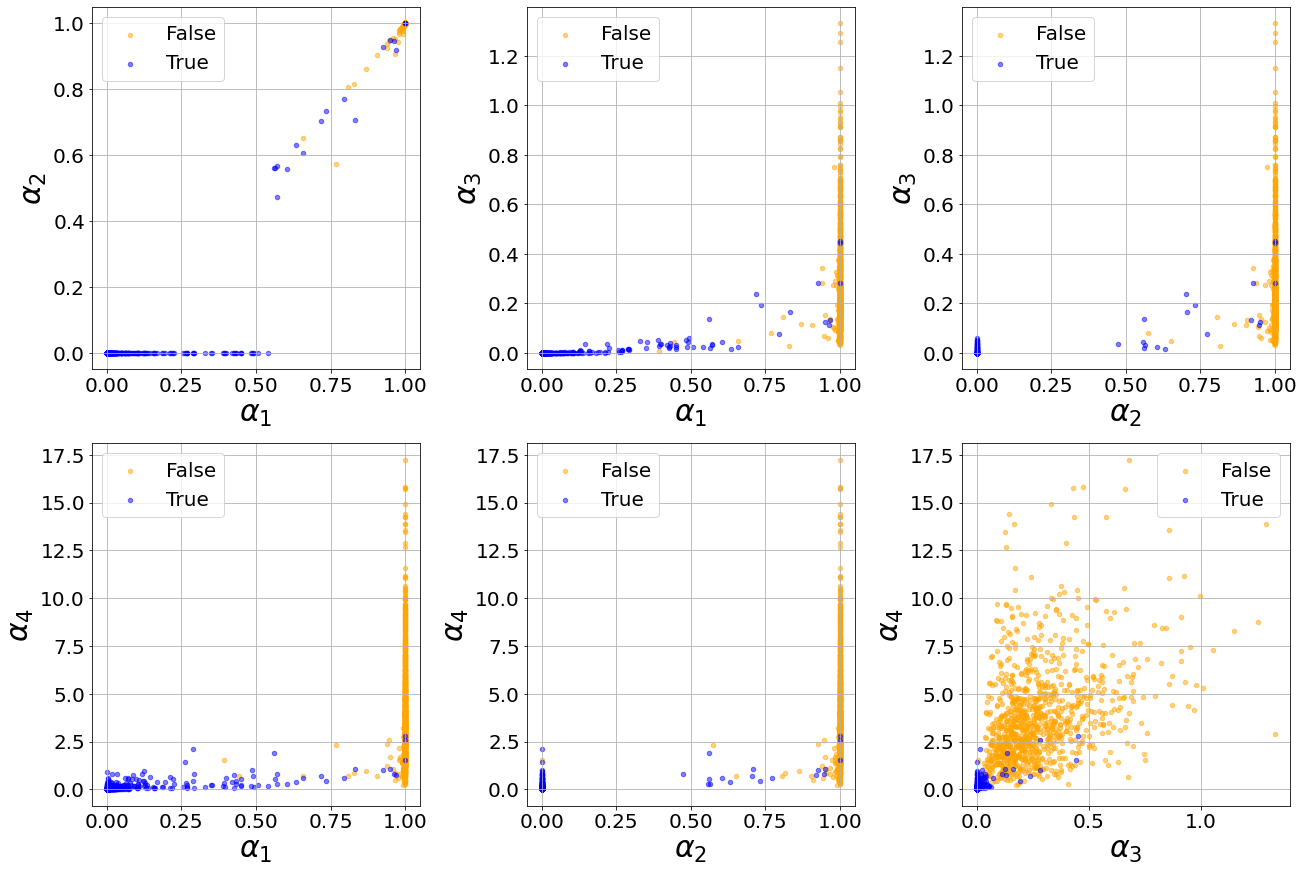

In [218]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
# plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=40) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend

alpha = 0.5
s = 20
N = 1000

ax[0][0].set_xlabel(r'$\alpha_1$')
ax[0][0].set_ylabel(r'$\alpha_2$')
ax[0][0].scatter(res1_test[:N], res2_test[:N], c='orange', label='False', alpha=alpha,  s=s)
ax[0][0].scatter(S1_test[:N], S2_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[0][0].legend()
ax[0][0].grid()

ax[0][1].set_xlabel(r'$\alpha_1$')
ax[0][1].set_ylabel(r'$\alpha_3$')
ax[0][1].scatter(res1_test[:N], res3_test[:N], c='orange', label='False', alpha=alpha,  s=s)
ax[0][1].scatter(S1_test[:N], S3_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[0][1].legend()
ax[0][1].grid()

ax[0][2].set_xlabel(r'$\alpha_2$')
ax[0][2].set_ylabel(r'$\alpha_3$')
ax[0][2].scatter(res2_test[:N], res3_test[:N], c='orange', label='False', alpha=alpha,  s=s)
ax[0][2].scatter(S2_test[:N], S3_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[0][2].legend()
ax[0][2].grid()

ax[1][0].set_xlabel(r'$\alpha_1$')
ax[1][0].set_ylabel(r'$\alpha_4$')
ax[1][0].scatter(res1_test[:N], res4_test[:N], c='orange', label='False', alpha=alpha,  s=s)
ax[1][0].scatter(S1_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
# ax[1][0].scatter(res1, np.sqrt(res4), c='red', label='False')
# ax[1][0].scatter(S1, np.sqrt(S4), c='blue', label='True')
ax[1][0].legend()
ax[1][0].grid()

ax[1][1].set_xlabel(r'$\alpha_2$')
ax[1][1].set_ylabel(r'$\alpha_4$')
ax[1][1].scatter(res2_test[:N], res4_test[:N], c='orange', label='False', alpha=alpha,  s=s)
ax[1][1].scatter(S2_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[1][1].legend()
ax[1][1].grid()

ax[1][2].set_xlabel(r'$\alpha_3$')
ax[1][2].set_ylabel(r'$\alpha_4$')
ax[1][2].scatter(res3_test[:N], res4_test[:N], c='orange', label='False', alpha=alpha,  s=s)
ax[1][2].scatter(S3_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[1][2].legend()
ax[1][2].grid()

plt.savefig("/content/pairewise.png")
plt.show()

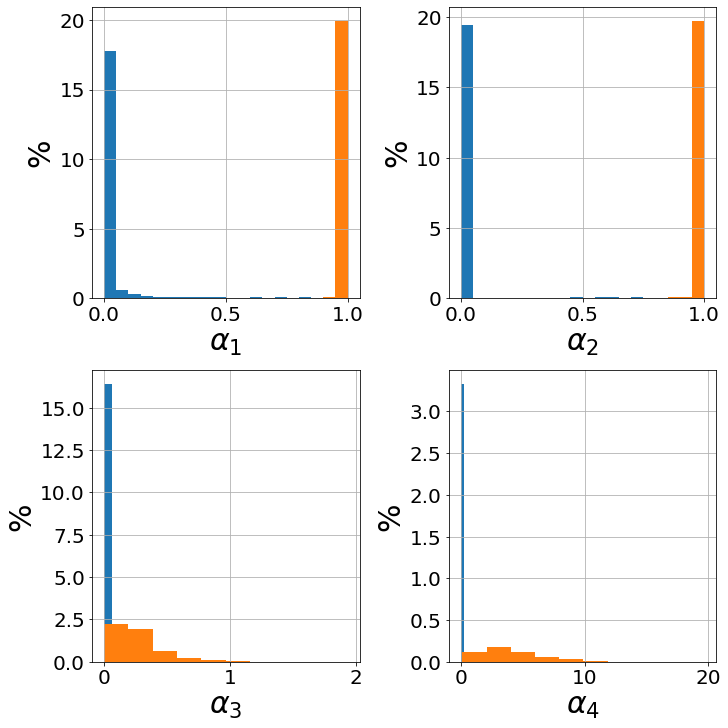

In [214]:
from torchvision.transforms.functional import normalize
# fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# plt.suptitle('Гистограммы')
fig, ax = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
# plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=40) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend

bins = 10
bins2 = 20

ax[0, 0].set_xlabel(r'$\alpha_1$')
ax[0, 0].set_ylabel('%')
ax[0, 0].hist(S1_test[:N], bins=bins2, density=True)
ax[0, 0].hist(res1_test[:N], bins=bins2, density=True)
ax[0, 0].grid()

ax[0, 1].set_xlabel(r'$\alpha_2$')
ax[0, 1].set_ylabel('%')
ax[0, 1].hist(S2_test[:N], bins=bins2, density=True)
ax[0, 1].hist(res2_test[:N], bins=bins2, density=True)
ax[0, 1].grid()

ax[1, 0].set_xlabel(r'$\alpha_3$')
ax[1, 0].set_ylabel('%')
ax[1, 0].hist(S3_test[:N], bins=bins, density=True)
ax[1, 0].hist(res3_test[:N], bins=bins, density=True)
ax[1, 0].grid()

ax[1, 1].set_xlabel(r'$\alpha_4$')
ax[1, 1].set_ylabel('%')
ax[1, 1].hist(S4_test[:N], bins=bins, density=True)
ax[1, 1].hist(res4_test[:N], bins=bins, density=True)
ax[1, 1].grid()

plt.savefig("/content/histograms.pdf")
plt.show()

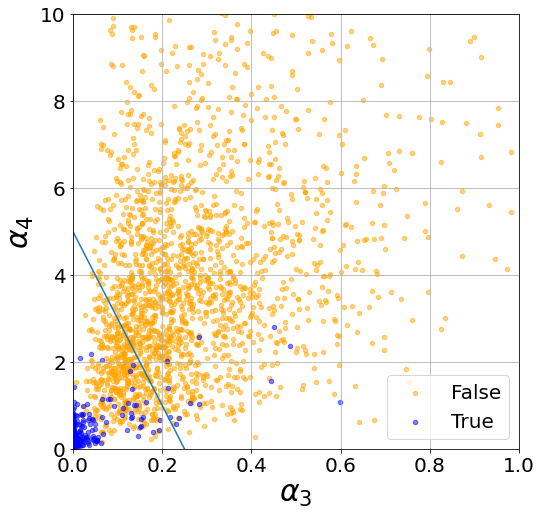

In [231]:
# fig, ax = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
# plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=40) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend

alpha = 0.5
s = 20
N = 2000

# ax[0][0].set_xlabel(r'$\alpha_1$')
# ax[0][0].set_ylabel(r'$\alpha_2$')
# ax[0][0].scatter(res1_test[:N], res2_test[:N], c='orange', label='False', alpha=alpha,  s=s)
# ax[0][0].scatter(S1_test[:N], S2_test[:N], c='blue', label='True', alpha=alpha,  s=s)
# ax[0][0].legend()
# ax[0][0].grid()

# ax[0][1].set_xlabel(r'$\alpha_1$')
# ax[0][1].set_ylabel(r'$\alpha_3$')
# ax[0][1].scatter(res1_test[:N], res3_test[:N], c='orange', label='False', alpha=alpha,  s=s)
# ax[0][1].scatter(S1_test[:N], S3_test[:N], c='blue', label='True', alpha=alpha,  s=s)
# ax[0][1].legend()
# ax[0][1].grid()

# ax[0][2].set_xlabel(r'$\alpha_2$')
# ax[0][2].set_ylabel(r'$\alpha_3$')
# ax[0][2].scatter(res2_test[:N], res3_test[:N], c='orange', label='False', alpha=alpha,  s=s)
# ax[0][2].scatter(S2_test[:N], S3_test[:N], c='blue', label='True', alpha=alpha,  s=s)
# ax[0][2].legend()
# ax[0][2].grid()

# ax[1][0].set_xlabel(r'$\alpha_1$')
# ax[1][0].set_ylabel(r'$\alpha_4$')
# ax[1][0].scatter(res1_test[:N], res4_test[:N], c='orange', label='False', alpha=alpha,  s=s)
# ax[1][0].scatter(S1_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
# # ax[1][0].scatter(res1, np.sqrt(res4), c='red', label='False')
# # ax[1][0].scatter(S1, np.sqrt(S4), c='blue', label='True')
# ax[1][0].legend()
# ax[1][0].grid()

# ax[1][1].set_xlabel(r'$\alpha_2$')
# ax[1][1].set_ylabel(r'$\alpha_4$')
# ax[1][1].scatter(res2_test[:N], res4_test[:N], c='orange', label='False', alpha=alpha,  s=s)
# ax[1][1].scatter(S2_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
# ax[1][1].legend()
# ax[1][1].grid()

plt.figure(figsize=(8,8)) 

plt.xlabel(r'$\alpha_3$')
plt.ylabel(r'$\alpha_4$')
plt.scatter(res3_test[:N], res4_test[:N], c='orange', label='False', alpha=alpha,  s=s)
plt.scatter(S3_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
plt.plot([0, 0.25], [5, 0])
plt.xlim([0, 1])
plt.ylim([0, 10])
plt.legend()
plt.grid()

plt.savefig("/content/pair.pdf")
plt.show()